In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql

In [5]:
# Database connection and data loading
host = "localhost"
port= 3306
database = 'burger_sales'
user = 'root'
password = 'ranjeetjb'

conn = pymysql.connect(host=host,
                      user=user,
                      password=password,
                      database=database,
                      port=port)
query = "SELECT * FROM burger_sales_data;"
df=pd.read_sql(query, conn)
conn.close()
print(df.head())

C:\Users\Ranjeet Kumar\AppData\Local\Temp\ipykernel_18300\4147388525.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


         Date Region  Temperature  Humidity       Wind  Visibility  \
0  15-09-2020   Reg1    10.248814  0.779164  11.509130   14.503403   
1  14-09-2020   Reg1    10.337595  0.908549   7.432656    2.232960   
2  13-09-2020   Reg1    20.763686  0.505324   7.788249    4.779211   
3  12-09-2020   Reg1    21.500892  0.758557   3.767432    9.904534   
4  11-09-2020   Reg1    21.774269  0.398296  20.705369   15.224605   

      Pressure    Sales  
0  1017.293917   991.60  
1  1019.452636  1858.59  
2  1022.677119     3.99  
3  1009.341357  3090.78  
4  1015.713234   990.99  


In [6]:
# Data preprocessing
print("Initial dataframe shape:", df.shape)
df['Date'] = pd.to_datetime(df['Date'])

Initial dataframe shape: (24500, 8)


C:\Users\Ranjeet Kumar\AppData\Local\Temp\ipykernel_18300\1053585986.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['Date'] = pd.to_datetime(df['Date'])


In [7]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Date           0
Region         0
Temperature    0
Humidity       0
Wind           0
Visibility     0
Pressure       0
Sales          0
dtype: int64


In [8]:
# Handle outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for column in ['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure', 'Sales']:
    df = remove_outliers_iqr(df, column)

In [10]:
# Feature scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df[['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure']] = scaler.fit_transform(df[['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure']])
df.head()

,Date,Region,Temperature,Humidity,Wind,Visibility,Pressure,Sales
0,2020-09-15,Reg1,0.427893,0.701469,0.392425,0.901183,0.533503,991.60
1,2020-09-14,Reg1,0.430073,0.877245,0.253430,0.138747,0.600887,1858.59
2,2020-09-13,Reg1,0.686189,0.329445,0.265555,0.296961,0.701538,3.99
3,2020-12-09,Reg1,0.704298,0.673474,0.128457,0.615428,0.285266,3090.78
4,2020-11-09,Reg1,0.711014,0.184043,0.705987,0.945995,0.484162,990.99


In [11]:
# Date-based feature engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.weekday
df.drop(columns=['Date'], inplace=True)

In [12]:
# One-hot encoding for 'Region'
df = pd.get_dummies(df, columns=['Region'], drop_first=True)

# Create lag features for 'Sales'
for lag in range(1, 6):
    df[f'Sales_Lag_{lag}'] = df['Sales'].shift(lag)

In [13]:
# Drop NaN rows introduced by lagging
df.dropna(inplace=True)
df.head()

,Temperature,Humidity,Wind,Visibility,Pressure,Sales,Year,Month,Day,Weekday,...,Region_Reg5,Region_Reg6,Region_Reg7,Region_Reg8,Region_Reg9,Sales_Lag_1,Sales_Lag_2,Sales_Lag_3,Sales_Lag_4,Sales_Lag_5
5,0.743128,0.287814,0.343295,0.347930,0.701305,31.93,2020,10,9,4,...,0,0,0,0,0,990.99,3090.78,3.99,1858.59,991.60
6,0.800871,0.586651,0.148473,0.547190,0.275896,3353.17,2020,9,9,2,...,0,0,0,0,0,31.93,990.99,3090.78,3.99,1858.59
7,0.802371,0.225116,0.619771,0.895143,0.439868,1584.29,2020,8,9,6,...,0,0,0,0,0,3353.17,31.93,990.99,3090.78,3.99
8,0.752722,0.273444,0.297526,0.256634,0.641040,107.60,2020,7,9,3,...,0,0,0,0,0,1584.29,3353.17,31.93,990.99,3090.78
9,0.776771,0.575068,0.212082,0.642786,0.335372,3108.91,2020,6,9,1,...,0,0,0,0,0,107.60,1584.29,3353.17,31.93,990.99


In [18]:
# Model training with LightGBM and Optuna
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', -1, 50),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10)
    }

    X = df.drop(columns=['Sales'])
    y = df['Sales']
    tscv = TimeSeriesSplit(n_splits=5)

    rmse_scores = []
    for train_index, test_index in tscv.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        model = lgb.train(params, train_data, valid_sets=[valid_data]) #early_stopping_rounds=50, verbose_eval=False)
        preds = model.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-12-20 01:28:55,244] A new study created in memory with name: no-name-b6cb6bba-e08e-477e-b055-4bfe7b1ce641


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:28:56,353] Trial 0 finished with value: 468.5269101979937 and parameters: {'learning_rate': 0.09311093126407767, 'num_leaves': 42, 'max_depth': 12, 'min_data_in_leaf': 85, 'feature_fraction': 0.6893209403450042, 'bagging_fraction': 0.984194030060935, 'bagging_freq': 9}. Best is trial 0 with value: 468.5269101979937.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:28:56,729] Trial 1 finished with value: 648.0894925387272 and parameters: {'learning_rate': 0.1208040073305478, 'num_leaves': 58, 'max_depth': 1, 'min_data_in_leaf': 74, 'feature_fraction': 0.6662027867613557, 'bagging_fraction': 0.801617132129892, 'bagging_freq': 8}. Best is trial 0 with value: 468.5269101979937.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 01:28:58,500] Trial 2 finished with value: 456.21933581077093 and parameters: {'learning_rate': 0.11438243521816652, 'num_leaves': 98, 'max_depth': 36, 'min_data_in_leaf': 38, 'feature_fraction': 0.7752931198227777, 'bagging_fraction': 0.804379548948284, 'bagging_freq': 9}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000561 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-12-20 01:28:59,097] Trial 3 finished with value: 478.99947235574 and parameters: {'learning_rate': 0.23969956300247128, 'num_leaves': 30, 'max_depth': 15, 'min_data_in_leaf': 50, 'feature_fraction': 0.9814146319216439, 'bagging_fraction': 0.6699559089332864, 'bagging_freq': 9}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:29:00,189] Trial 4 finished with value: 475.90088246978075 and parameters: {'learning_rate': 0.1924759389644567, 'num_leaves': 76, 'max_depth': 28, 'min_data_in_leaf': 23, 'feature_fraction': 0.6459637265779284, 'bagging_fraction': 0.7206295909718223, 'bagging_freq': 2}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points i

[I 2024-12-20 01:29:00,958] Trial 5 finished with value: 482.9436854002835 and parameters: {'learning_rate': 0.27698619366857535, 'num_leaves': 46, 'max_depth': 19, 'min_data_in_leaf': 47, 'feature_fraction': 0.6401570954684704, 'bagging_fraction': 0.803330534248048, 'bagging_freq': 4}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:29:01,632] Trial 6 finished with value: 463.9120296167106 and parameters: {'learning_rate': 0.1450211773667216, 'num_leaves': 34, 'max_depth': 28, 'min_data_in_leaf': 33, 'feature_fraction': 0.9132277181874016, 'bagging_fraction': 0.7241525114070356, 'bagging_freq': 5}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000493 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:02,437] Trial 7 finished with value: 472.9671998311977 and parameters: {'learning_rate': 0.23964789102117262, 'num_leaves': 49, 'max_depth': 48, 'min_data_in_leaf': 45, 'feature_fraction': 0.7926565970862021, 'bagging_fraction': 0.8785881866396585, 'bagging_freq': 2}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2024-12-20 01:29:03,298] Trial 8 finished with value: 523.5271752659628 and parameters: {'learning_rate': 0.020583550206893262, 'num_leaves': 47, 'max_depth': 14, 'min_data_in_leaf': 59, 'feature_fraction': 0.8812652794602269, 'bagging_fraction': 0.8870339909553375, 'bagging_freq': 5}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:29:03,916] Trial 9 finished with value: 467.83059508522575 and parameters: {'learning_rate': 0.10532513015398035, 'num_leaves': 30, 'max_depth': 32, 'min_data_in_leaf': 21, 'feature_fraction': 0.8858281591272512, 'bagging_fraction': 0.619973919622254, 'bagging_freq': 5}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] 

[I 2024-12-20 01:29:05,062] Trial 10 finished with value: 485.34708559037665 and parameters: {'learning_rate': 0.032446111032011365, 'num_leaves': 96, 'max_depth': 43, 'min_data_in_leaf': 99, 'feature_fraction': 0.7669851501529122, 'bagging_fraction': 0.9984631473060603, 'bagging_freq': 7}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:06,464] Trial 11 finished with value: 464.5665551696385 and parameters: {'learning_rate': 0.17297179795303635, 'num_leaves': 100, 'max_depth': 37, 'min_data_in_leaf': 32, 'feature_fraction': 0.887539901281715, 'bagging_fraction': 0.7331627599378587, 'bagging_freq': 7}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:07,604] Trial 12 finished with value: 461.73963545124553 and parameters: {'learning_rate': 0.1411387893192791, 'num_leaves': 76, 'max_depth': 34, 'min_data_in_leaf': 10, 'feature_fraction': 0.9942400280250694, 'bagging_fraction': 0.736076992215593, 'bagging_freq': 10}. Best is trial 2 with value: 456.21933581077093.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:08,867] Trial 13 finished with value: 454.0882559951725 and parameters: {'learning_rate': 0.0678432800680531, 'num_leaves': 81, 'max_depth': 38, 'min_data_in_leaf': 11, 'feature_fraction': 0.7377692158520639, 'bagging_fraction': 0.8541831492412384, 'bagging_freq': 10}. Best is trial 13 with value: 454.0882559951725.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:10,108] Trial 14 finished with value: 454.0859422823437 and parameters: {'learning_rate': 0.0682657581132858, 'num_leaves': 82, 'max_depth': 41, 'min_data_in_leaf': 10, 'feature_fraction': 0.730075698015705, 'bagging_fraction': 0.8762314072324096, 'bagging_freq': 10}. Best is trial 14 with value: 454.0859422823437.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:11,248] Trial 15 finished with value: 455.73030718377987 and parameters: {'learning_rate': 0.06278892586876865, 'num_leaves': 76, 'max_depth': 50, 'min_data_in_leaf': 12, 'feature_fraction': 0.7201202518607672, 'bagging_fraction': 0.9035811124058634, 'bagging_freq': 10}. Best is trial 14 with value: 454.0859422823437.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:12,511] Trial 16 finished with value: 453.9586412440196 and parameters: {'learning_rate': 0.06818594096696624, 'num_leaves': 84, 'max_depth': 41, 'min_data_in_leaf': 22, 'feature_fraction': 0.7433072803037957, 'bagging_fraction': 0.9373382375110814, 'bagging_freq': 7}. Best is trial 16 with value: 453.9586412440196.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:13,893] Trial 17 finished with value: 452.4499030805574 and parameters: {'learning_rate': 0.05276129750545615, 'num_leaves': 86, 'max_depth': 43, 'min_data_in_leaf': 22, 'feature_fraction': 0.8375585585043862, 'bagging_fraction': 0.9441252115375802, 'bagging_freq': 7}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:14,990] Trial 18 finished with value: 460.7238229368472 and parameters: {'learning_rate': 0.04468537980018698, 'num_leaves': 64, 'max_depth': 45, 'min_data_in_leaf': 23, 'feature_fraction': 0.839128234093036, 'bagging_fraction': 0.9469703978936984, 'bagging_freq': 7}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:16,441] Trial 19 finished with value: 629.8081583981755 and parameters: {'learning_rate': 0.010606804638735312, 'num_leaves': 88, 'max_depth': 25, 'min_data_in_leaf': 61, 'feature_fraction': 0.8276626115514195, 'bagging_fraction': 0.9411852717687482, 'bagging_freq': 6}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000621 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:17,509] Trial 20 finished with value: 453.3913944395548 and parameters: {'learning_rate': 0.082027838120081, 'num_leaves': 66, 'max_depth': 44, 'min_data_in_leaf': 31, 'feature_fraction': 0.8330053884344578, 'bagging_fraction': 0.9406987553846574, 'bagging_freq': 3}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:18,608] Trial 21 finished with value: 454.0877399836469 and parameters: {'learning_rate': 0.08705282004857641, 'num_leaves': 65, 'max_depth': 44, 'min_data_in_leaf': 28, 'feature_fraction': 0.8398578467965777, 'bagging_fraction': 0.9393575397712486, 'bagging_freq': 1}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:29:19,767] Trial 22 finished with value: 458.9830608340746 and parameters: {'learning_rate': 0.04762451826224841, 'num_leaves': 69, 'max_depth': 50, 'min_data_in_leaf': 38, 'feature_fraction': 0.8178253935494446, 'bagging_fraction': 0.9639004570044922, 'bagging_freq': 3}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:21,143] Trial 23 finished with value: 453.0029697522067 and parameters: {'learning_rate': 0.0786080475673741, 'num_leaves': 87, 'max_depth': 40, 'min_data_in_leaf': 19, 'feature_fraction': 0.7579235711127965, 'bagging_fraction': 0.913630679696322, 'bagging_freq': 6}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:22,912] Trial 24 finished with value: 459.98374792803554 and parameters: {'learning_rate': 0.09148526454591946, 'num_leaves': 89, 'max_depth': 31, 'min_data_in_leaf': 18, 'feature_fraction': 0.6066411342370844, 'bagging_fraction': 0.8385728202987474, 'bagging_freq': 4}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:23,608] Trial 25 finished with value: 472.11625468184485 and parameters: {'learning_rate': 0.12828068381457, 'num_leaves': 21, 'max_depth': 39, 'min_data_in_leaf': 39, 'feature_fraction': 0.9314617772015519, 'bagging_fraction': 0.9082428413442912, 'bagging_freq': 6}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:29:24,580] Trial 26 finished with value: 462.42068579537136 and parameters: {'learning_rate': 0.16789126180647151, 'num_leaves': 56, 'max_depth': 46, 'min_data_in_leaf': 29, 'feature_fraction': 0.8519465344705951, 'bagging_fraction': 0.9169059931439049, 'bagging_freq': 4}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:29:26,259] Trial 27 finished with value: 461.5408159793092 and parameters: {'learning_rate': 0.034139144796244705, 'num_leaves': 91, 'max_depth': 0, 'min_data_in_leaf': 17, 'feature_fraction': 0.8013757670953185, 'bagging_fraction': 0.9754447764882189, 'bagging_freq': 6}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:27,399] Trial 28 finished with value: 460.1445568789571 and parameters: {'learning_rate': 0.08577351106918736, 'num_leaves': 71, 'max_depth': 42, 'min_data_in_leaf': 67, 'feature_fraction': 0.9508361726581886, 'bagging_fraction': 0.8426254155833475, 'bagging_freq': 3}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:28,828] Trial 29 finished with value: 454.1226853488764 and parameters: {'learning_rate': 0.09443993635391121, 'num_leaves': 95, 'max_depth': 21, 'min_data_in_leaf': 28, 'feature_fraction': 0.6964050120387492, 'bagging_fraction': 0.9727266382519759, 'bagging_freq': 8}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-12-20 01:29:29,738] Trial 30 finished with value: 470.6208186484181 and parameters: {'learning_rate': 0.1950597992665265, 'num_leaves': 54, 'max_depth': 47, 'min_data_in_leaf': 41, 'feature_fraction': 0.7761739270746233, 'bagging_fraction': 0.770763588753583, 'bagging_freq': 8}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000668 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:29:31,140] Trial 31 finished with value: 453.1808591207814 and parameters: {'learning_rate': 0.05870193854109704, 'num_leaves': 86, 'max_depth': 40, 'min_data_in_leaf': 18, 'feature_fraction': 0.7578356077214788, 'bagging_fraction': 0.9324966539854009, 'bagging_freq': 7}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:31,717] Trial 32 finished with value: 518.6601685611947 and parameters: {'learning_rate': 0.0501973514363962, 'num_leaves': 85, 'max_depth': 4, 'min_data_in_leaf': 18, 'feature_fraction': 0.8682975628500433, 'bagging_fraction': 0.9244406757860648, 'bagging_freq': 6}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000917 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2024-12-20 01:29:33,210] Trial 33 finished with value: 453.7733599953731 and parameters: {'learning_rate': 0.11505681185396865, 'num_leaves': 93, 'max_depth': 36, 'min_data_in_leaf': 27, 'feature_fraction': 0.7581552135683988, 'bagging_fraction': 0.9933266328514104, 'bagging_freq': 8}. Best is trial 17 with value: 452.4499030805574.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points i

[I 2024-12-20 01:29:34,903] Trial 34 finished with value: 452.2229352037718 and parameters: {'learning_rate': 0.07669512546867341, 'num_leaves': 79, 'max_depth': 39, 'min_data_in_leaf': 35, 'feature_fraction': 0.8048861263708995, 'bagging_fraction': 0.9609718229435757, 'bagging_freq': 7}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:36,460] Trial 35 finished with value: 475.75151510335456 and parameters: {'learning_rate': 0.029917007295997784, 'num_leaves': 79, 'max_depth': 33, 'min_data_in_leaf': 16, 'feature_fraction': 0.7119508858300663, 'bagging_fraction': 0.9629912147223292, 'bagging_freq': 8}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000354 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:37,423] Trial 36 finished with value: 467.2466132928083 and parameters: {'learning_rate': 0.10753999972287373, 'num_leaves': 73, 'max_depth': 8, 'min_data_in_leaf': 85, 'feature_fraction': 0.7991072283360103, 'bagging_fraction': 0.9007639642738056, 'bagging_freq': 9}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 01:29:38,986] Trial 37 finished with value: 457.445261180716 and parameters: {'learning_rate': 0.05712153506392288, 'num_leaves': 91, 'max_depth': 40, 'min_data_in_leaf': 24, 'feature_fraction': 0.681510205619673, 'bagging_fraction': 0.823381972856156, 'bagging_freq': 7}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:40,451] Trial 38 finished with value: 456.9193914226048 and parameters: {'learning_rate': 0.12853395256312328, 'num_leaves': 86, 'max_depth': 28, 'min_data_in_leaf': 35, 'feature_fraction': 0.758551572541271, 'bagging_fraction': 0.8614736899561548, 'bagging_freq': 6}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:41,832] Trial 39 finished with value: 581.908525013526 and parameters: {'learning_rate': 0.013690376928627457, 'num_leaves': 79, 'max_depth': 36, 'min_data_in_leaf': 52, 'feature_fraction': 0.7847149441511732, 'bagging_fraction': 0.7788369029928502, 'bagging_freq': 5}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000691 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:42,915] Trial 40 finished with value: 473.4160440121618 and parameters: {'learning_rate': 0.28090844948555105, 'num_leaves': 61, 'max_depth': 30, 'min_data_in_leaf': 43, 'feature_fraction': 0.8158060965823749, 'bagging_fraction': 0.9530910066211069, 'bagging_freq': 7}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:44,526] Trial 41 finished with value: 454.1646580442214 and parameters: {'learning_rate': 0.07972766805284547, 'num_leaves': 68, 'max_depth': 44, 'min_data_in_leaf': 35, 'feature_fraction': 0.8058459030557968, 'bagging_fraction': 0.9216799170182379, 'bagging_freq': 6}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:45,875] Trial 42 finished with value: 452.73589395744995 and parameters: {'learning_rate': 0.07601555049285955, 'num_leaves': 75, 'max_depth': 48, 'min_data_in_leaf': 15, 'feature_fraction': 0.8551347433628906, 'bagging_fraction': 0.8908474088784594, 'bagging_freq': 7}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train

[I 2024-12-20 01:29:47,179] Trial 43 finished with value: 453.23711926173274 and parameters: {'learning_rate': 0.1000682707491441, 'num_leaves': 75, 'max_depth': 47, 'min_data_in_leaf': 14, 'feature_fraction': 0.8587555713429427, 'bagging_fraction': 0.8906742484164484, 'bagging_freq': 9}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:48,803] Trial 44 finished with value: 457.3385785254748 and parameters: {'learning_rate': 0.037549203980064026, 'num_leaves': 99, 'max_depth': 49, 'min_data_in_leaf': 20, 'feature_fraction': 0.9018379099414431, 'bagging_fraction': 0.8712152087069371, 'bagging_freq': 8}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:50,185] Trial 45 finished with value: 452.77891806157214 and parameters: {'learning_rate': 0.07265001617996979, 'num_leaves': 82, 'max_depth': 39, 'min_data_in_leaf': 24, 'feature_fraction': 0.7615438089127524, 'bagging_fraction': 0.9842643185632238, 'bagging_freq': 7}. Best is trial 34 with value: 452.2229352037718.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:51,532] Trial 46 finished with value: 451.53206868069566 and parameters: {'learning_rate': 0.07508229549990508, 'num_leaves': 82, 'max_depth': 38, 'min_data_in_leaf': 26, 'feature_fraction': 0.7892090721773536, 'bagging_fraction': 0.9850651901830462, 'bagging_freq': 5}. Best is trial 46 with value: 451.53206868069566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:52,789] Trial 47 finished with value: 461.06922388066175 and parameters: {'learning_rate': 0.22656747229612878, 'num_leaves': 79, 'max_depth': 37, 'min_data_in_leaf': 25, 'feature_fraction': 0.8725476939796183, 'bagging_fraction': 0.9865977010269664, 'bagging_freq': 5}. Best is trial 46 with value: 451.53206868069566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:29:54,358] Trial 48 finished with value: 497.12924881788086 and parameters: {'learning_rate': 0.023439551408177106, 'num_leaves': 82, 'max_depth': 22, 'min_data_in_leaf': 46, 'feature_fraction': 0.7801909709445963, 'bagging_fraction': 0.9944263639655662, 'bagging_freq': 9}. Best is trial 46 with value: 451.53206868069566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:55,816] Trial 49 finished with value: 452.24388717148497 and parameters: {'learning_rate': 0.07292405334003839, 'num_leaves': 78, 'max_depth': 42, 'min_data_in_leaf': 33, 'feature_fraction': 0.9125078621471988, 'bagging_fraction': 0.9748753598590825, 'bagging_freq': 7}. Best is trial 46 with value: 451.53206868069566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000442 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000703 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:57,337] Trial 50 finished with value: 455.90656782751995 and parameters: {'learning_rate': 0.15557870937225257, 'num_leaves': 73, 'max_depth': 34, 'min_data_in_leaf': 33, 'feature_fraction': 0.9604798390375252, 'bagging_fraction': 0.9599206190170251, 'bagging_freq': 5}. Best is trial 46 with value: 451.53206868069566.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:29:58,767] Trial 51 finished with value: 450.67628503412595 and parameters: {'learning_rate': 0.07828327259775356, 'num_leaves': 77, 'max_depth': 42, 'min_data_in_leaf': 25, 'feature_fraction': 0.9204137416868511, 'bagging_fraction': 0.9781760009467881, 'bagging_freq': 7}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:30:00,211] Trial 52 finished with value: 454.17575247456 and parameters: {'learning_rate': 0.10407616283009398, 'num_leaves': 77, 'max_depth': 43, 'min_data_in_leaf': 49, 'feature_fraction': 0.9016777519021298, 'bagging_fraction': 0.9722688352683778, 'bagging_freq': 8}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:01,754] Trial 53 finished with value: 457.12840308693666 and parameters: {'learning_rate': 0.05371244471922747, 'num_leaves': 72, 'max_depth': 46, 'min_data_in_leaf': 37, 'feature_fraction': 0.922407889294531, 'bagging_fraction': 0.9972339380447434, 'bagging_freq': 7}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:03,245] Trial 54 finished with value: 456.3475257189033 and parameters: {'learning_rate': 0.04121700112752677, 'num_leaves': 83, 'max_depth': 42, 'min_data_in_leaf': 14, 'feature_fraction': 0.9377465578568152, 'bagging_fraction': 0.9499966390932424, 'bagging_freq': 7}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:04,537] Trial 55 finished with value: 454.69676175744314 and parameters: {'learning_rate': 0.12113998158740998, 'num_leaves': 69, 'max_depth': 48, 'min_data_in_leaf': 30, 'feature_fraction': 0.9002040481639707, 'bagging_fraction': 0.9799686026519321, 'bagging_freq': 8}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:05,395] Trial 56 finished with value: 466.35215161940744 and parameters: {'learning_rate': 0.07026408916258131, 'num_leaves': 41, 'max_depth': 45, 'min_data_in_leaf': 26, 'feature_fraction': 0.9835884517935753, 'bagging_fraction': 0.6108505251969285, 'bagging_freq': 4}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2626
[LightGBM] [Info] Number of data points in the train set: 19753, number of used features: 22
[LightGBM] [Info] Start training from score 1852.466507
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start

[I 2024-12-20 01:30:06,547] Trial 57 finished with value: 454.5226036165874 and parameters: {'learning_rate': 0.09497809343259454, 'num_leaves': 60, 'max_depth': 38, 'min_data_in_leaf': 22, 'feature_fraction': 0.9630123194680275, 'bagging_fraction': 0.9556998543109011, 'bagging_freq': 6}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:30:07,772] Trial 58 finished with value: 491.07098741857925 and parameters: {'learning_rate': 0.2936518682477918, 'num_leaves': 78, 'max_depth': 35, 'min_data_in_leaf': 57, 'feature_fraction': 0.8514850933196465, 'bagging_fraction': 0.7035001063997995, 'bagging_freq': 5}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:09,101] Trial 59 finished with value: 455.4676705491946 and parameters: {'learning_rate': 0.06477482109791727, 'num_leaves': 75, 'max_depth': 42, 'min_data_in_leaf': 33, 'feature_fraction': 0.888143894128993, 'bagging_fraction': 0.8905181328606908, 'bagging_freq': 7}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:10,806] Trial 60 finished with value: 451.3043958312226 and parameters: {'learning_rate': 0.07706946492406008, 'num_leaves': 89, 'max_depth': 50, 'min_data_in_leaf': 13, 'feature_fraction': 0.8236730089120479, 'bagging_fraction': 0.925620918480924, 'bagging_freq': 6}. Best is trial 51 with value: 450.67628503412595.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:12,354] Trial 61 finished with value: 449.0320028718423 and parameters: {'learning_rate': 0.07733030154130147, 'num_leaves': 91, 'max_depth': 50, 'min_data_in_leaf': 15, 'feature_fraction': 0.8262811005666433, 'bagging_fraction': 0.9248441387463565, 'bagging_freq': 6}. Best is trial 61 with value: 449.0320028718423.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:13,953] Trial 62 finished with value: 447.8782590456593 and parameters: {'learning_rate': 0.08541653417499204, 'num_leaves': 96, 'max_depth': 50, 'min_data_in_leaf': 12, 'feature_fraction': 0.8203506164026696, 'bagging_fraction': 0.9674314852097137, 'bagging_freq': 6}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000512 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:15,490] Trial 63 finished with value: 453.01432123288896 and parameters: {'learning_rate': 0.11289855666457077, 'num_leaves': 96, 'max_depth': 48, 'min_data_in_leaf': 10, 'feature_fraction': 0.792587406045077, 'bagging_fraction': 0.9288539027085424, 'bagging_freq': 6}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:16,979] Trial 64 finished with value: 450.0149930301408 and parameters: {'learning_rate': 0.08243300099990752, 'num_leaves': 90, 'max_depth': 49, 'min_data_in_leaf': 13, 'feature_fraction': 0.8188130813062877, 'bagging_fraction': 0.9657507795163343, 'bagging_freq': 6}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:18,478] Trial 65 finished with value: 451.0741433518445 and parameters: {'learning_rate': 0.08679894215365241, 'num_leaves': 91, 'max_depth': 50, 'min_data_in_leaf': 11, 'feature_fraction': 0.8223773322333794, 'bagging_fraction': 0.9670879912526135, 'bagging_freq': 5}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:20,280] Trial 66 finished with value: 450.0068435048723 and parameters: {'learning_rate': 0.08855689760073976, 'num_leaves': 91, 'max_depth': 50, 'min_data_in_leaf': 12, 'feature_fraction': 0.8221433984935835, 'bagging_fraction': 0.9698066970329031, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:21,776] Trial 67 finished with value: 453.5893078373999 and parameters: {'learning_rate': 0.1330898456756603, 'num_leaves': 93, 'max_depth': 50, 'min_data_in_leaf': 12, 'feature_fraction': 0.8237992782447019, 'bagging_fraction': 0.9393558782304712, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:23,359] Trial 68 finished with value: 449.3102298670712 and parameters: {'learning_rate': 0.08897001677731908, 'num_leaves': 98, 'max_depth': 50, 'min_data_in_leaf': 12, 'feature_fraction': 0.832176372400456, 'bagging_fraction': 0.9678107771642588, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:24,977] Trial 69 finished with value: 448.96105416826623 and parameters: {'learning_rate': 0.08886523238166234, 'num_leaves': 100, 'max_depth': 46, 'min_data_in_leaf': 10, 'feature_fraction': 0.8359243914851389, 'bagging_fraction': 0.9681317931816911, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:26,560] Trial 70 finished with value: 455.02752845727247 and parameters: {'learning_rate': 0.09777122180460138, 'num_leaves': 100, 'max_depth': 46, 'min_data_in_leaf': 16, 'feature_fraction': 0.8403089252873331, 'bagging_fraction': 0.6448472914521105, 'bagging_freq': 3}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:28,415] Trial 71 finished with value: 450.4388629302786 and parameters: {'learning_rate': 0.08764423443016514, 'num_leaves': 95, 'max_depth': 49, 'min_data_in_leaf': 10, 'feature_fraction': 0.8142977398616591, 'bagging_fraction': 0.9733377320249714, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000475 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:29,990] Trial 72 finished with value: 450.8848920063559 and parameters: {'learning_rate': 0.09076699975088148, 'num_leaves': 98, 'max_depth': 48, 'min_data_in_leaf': 13, 'feature_fraction': 0.8152892805096683, 'bagging_fraction': 0.9993449495634388, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:31,552] Trial 73 finished with value: 450.2288726627876 and parameters: {'learning_rate': 0.11019149548426146, 'num_leaves': 96, 'max_depth': 45, 'min_data_in_leaf': 19, 'feature_fraction': 0.8470285758352295, 'bagging_fraction': 0.9510794516080485, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:33,073] Trial 74 finished with value: 450.0304381400222 and parameters: {'learning_rate': 0.10917416823097528, 'num_leaves': 94, 'max_depth': 46, 'min_data_in_leaf': 10, 'feature_fraction': 0.8421527893435635, 'bagging_fraction': 0.9505164513501009, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000499 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:34,641] Trial 75 finished with value: 451.6068037708563 and parameters: {'learning_rate': 0.11742683220239516, 'num_leaves': 97, 'max_depth': 45, 'min_data_in_leaf': 20, 'feature_fraction': 0.8467794357135984, 'bagging_fraction': 0.9512162929872624, 'bagging_freq': 3}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000514 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:36,139] Trial 76 finished with value: 455.1469265743399 and parameters: {'learning_rate': 0.14573387769066362, 'num_leaves': 94, 'max_depth': 47, 'min_data_in_leaf': 16, 'feature_fraction': 0.8670592206864438, 'bagging_fraction': 0.9122868197217683, 'bagging_freq': 4}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:37,926] Trial 77 finished with value: 450.1676128163708 and parameters: {'learning_rate': 0.1079131155006918, 'num_leaves': 92, 'max_depth': 45, 'min_data_in_leaf': 19, 'feature_fraction': 0.8326788743065672, 'bagging_fraction': 0.9343717198160308, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:39,315] Trial 78 finished with value: 449.2886573396101 and parameters: {'learning_rate': 0.12150471230480211, 'num_leaves': 90, 'max_depth': 49, 'min_data_in_leaf': 14, 'feature_fraction': 0.833677802605524, 'bagging_fraction': 0.9368124879000695, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:30:40,527] Trial 79 finished with value: 460.56288325560706 and parameters: {'learning_rate': 0.12441962490626524, 'num_leaves': 89, 'max_depth': 49, 'min_data_in_leaf': 98, 'feature_fraction': 0.8773964819021539, 'bagging_fraction': 0.9389412557288501, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:42,136] Trial 80 finished with value: 452.7626905664837 and parameters: {'learning_rate': 0.13576960184186687, 'num_leaves': 100, 'max_depth': 47, 'min_data_in_leaf': 13, 'feature_fraction': 0.8645613334908515, 'bagging_fraction': 0.9063757876560261, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:43,629] Trial 81 finished with value: 450.30329622421095 and parameters: {'learning_rate': 0.10327812141818778, 'num_leaves': 92, 'max_depth': 50, 'min_data_in_leaf': 10, 'feature_fraction': 0.8352188665153688, 'bagging_fraction': 0.9293272563400616, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:45,251] Trial 82 finished with value: 450.45351085730107 and parameters: {'learning_rate': 0.09888034744886295, 'num_leaves': 88, 'max_depth': 44, 'min_data_in_leaf': 16, 'feature_fraction': 0.8318945703923544, 'bagging_fraction': 0.9647225955017508, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:30:46,876] Trial 83 finished with value: 449.4019172833986 and parameters: {'learning_rate': 0.061328026924020625, 'num_leaves': 98, 'max_depth': 17, 'min_data_in_leaf': 21, 'feature_fraction': 0.8093171273332604, 'bagging_fraction': 0.9453313007852814, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000312 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM]

[I 2024-12-20 01:30:48,590] Trial 84 finished with value: 450.33643130169895 and parameters: {'learning_rate': 0.0580796025551919, 'num_leaves': 98, 'max_depth': 16, 'min_data_in_leaf': 21, 'feature_fraction': 0.804231477674693, 'bagging_fraction': 0.9583546740579995, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:50,088] Trial 85 finished with value: 448.9503274994851 and parameters: {'learning_rate': 0.06281145211811888, 'num_leaves': 94, 'max_depth': 47, 'min_data_in_leaf': 14, 'feature_fraction': 0.8054768629158486, 'bagging_fraction': 0.945916177020753, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading

[I 2024-12-20 01:30:51,639] Trial 86 finished with value: 451.49217513036604 and parameters: {'learning_rate': 0.06351874845370245, 'num_leaves': 97, 'max_depth': 16, 'min_data_in_leaf': 17, 'feature_fraction': 0.7706876222692972, 'bagging_fraction': 0.9200782827671832, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000448 seconds.
You can set `force_col_wise

[I 2024-12-20 01:30:53,264] Trial 87 finished with value: 453.3327679242387 and parameters: {'learning_rate': 0.0467896029839528, 'num_leaves': 90, 'max_depth': 10, 'min_data_in_leaf': 14, 'feature_fraction': 0.8096016510982479, 'bagging_fraction': 0.9860182898851031, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:30:54,576] Trial 88 finished with value: 456.178117919897 and parameters: {'learning_rate': 0.08577561847491644, 'num_leaves': 87, 'max_depth': 19, 'min_data_in_leaf': 72, 'feature_fraction': 0.7963728543476125, 'bagging_fraction': 0.9452502005481234, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points i

[I 2024-12-20 01:30:56,270] Trial 89 finished with value: 449.6746012729115 and parameters: {'learning_rate': 0.06365200918302696, 'num_leaves': 100, 'max_depth': 26, 'min_data_in_leaf': 12, 'feature_fraction': 0.7870892149398714, 'bagging_fraction': 0.9660010884545265, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:30:57,822] Trial 90 finished with value: 451.38577327946325 and parameters: {'learning_rate': 0.06256603320442841, 'num_leaves': 100, 'max_depth': 26, 'min_data_in_leaf': 15, 'feature_fraction': 0.7374549643810485, 'bagging_fraction': 0.9868064728864225, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:30:58,219] Trial 91 finished with value: 542.1599925604797 and parameters: {'learning_rate': 0.06861029972251573, 'num_leaves': 95, 'max_depth': 3, 'min_data_in_leaf': 13, 'feature_fraction': 0.7906740701299788, 'bagging_fraction': 0.9673139597676526, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-12-20 01:31:00,316] Trial 92 finished with value: 449.2297498872009 and parameters: {'learning_rate': 0.08400083212200651, 'num_leaves': 98, 'max_depth': 49, 'min_data_in_leaf': 18, 'feature_fraction': 0.7784610825547804, 'bagging_fraction': 0.9639046511228527, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000538 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:31:02,584] Trial 93 finished with value: 450.61435212907753 and parameters: {'learning_rate': 0.053901944265195914, 'num_leaves': 98, 'max_depth': 47, 'min_data_in_leaf': 18, 'feature_fraction': 0.7773807556441704, 'bagging_fraction': 0.9391525913328086, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:31:04,485] Trial 94 finished with value: 452.5613678245571 and parameters: {'learning_rate': 0.09277514085121803, 'num_leaves': 94, 'max_depth': 49, 'min_data_in_leaf': 22, 'feature_fraction': 0.783541600735861, 'bagging_fraction': 0.9166330639723653, 'bagging_freq': 3}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000611 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:31:06,548] Trial 95 finished with value: 449.80551704447635 and parameters: {'learning_rate': 0.05978549554390807, 'num_leaves': 97, 'max_depth': 23, 'min_data_in_leaf': 12, 'feature_fraction': 0.7962341785795132, 'bagging_fraction': 0.8991487757206436, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000513 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:31:08,814] Trial 96 finished with value: 449.77363827068655 and parameters: {'learning_rate': 0.06054838989533454, 'num_leaves': 98, 'max_depth': 22, 'min_data_in_leaf': 17, 'feature_fraction': 0.748377809813841, 'bagging_fraction': 0.8986828199219734, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:31:11,314] Trial 97 finished with value: 455.9495666017824 and parameters: {'learning_rate': 0.042077277684986356, 'num_leaves': 100, 'max_depth': 20, 'min_data_in_leaf': 23, 'feature_fraction': 0.7631455656661934, 'bagging_fraction': 0.9327538712041202, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000615 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2620
[LightGBM] [Info] Number of data points in the train set: 11853, number of used features: 19
[LightGBM] [Info] Start

[I 2024-12-20 01:31:13,455] Trial 98 finished with value: 464.1026612312823 and parameters: {'learning_rate': 0.03327797839439499, 'num_leaves': 96, 'max_depth': 17, 'min_data_in_leaf': 17, 'feature_fraction': 0.7701446639803116, 'bagging_fraction': 0.8788115278269026, 'bagging_freq': 1}. Best is trial 62 with value: 447.8782590456593.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-12-20 01:31:15,768] Trial 99 finished with value: 452.00346114397354 and parameters: {'learning_rate': 0.07056328327859625, 'num_leaves': 98, 'max_depth': 13, 'min_data_in_leaf': 20, 'feature_fraction': 0.7493381512903193, 'bagging_fraction': 0.81509834582924, 'bagging_freq': 2}. Best is trial 62 with value: 447.8782590456593.


In [19]:
# Final training with best parameters
params = study.best_params
X = df.drop(columns=['Sales'])
y = df['Sales']

rmse_scores = []
ts_split = TimeSeriesSplit(n_splits=5)

for train_index, test_index in ts_split.split(X):
    X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
    callbacks = [lgb.early_stopping(stopping_rounds=50)]
    model = lgb.train(
        params,
        train_data,
        num_boost_round=1000,
        valid_sets=[valid_data],
        callbacks=callbacks
    )
    preds = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, preds))
    rmse_scores.append(rmse)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2612
[LightGBM] [Info] Number of data points in the train set: 3953, number of used features: 15
[LightGBM] [Info] Start training from score 1875.476969
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 249552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2616
[LightGBM] [Info] Number of data points in the train set: 7903, number of used features: 17
[LightGBM] [Info] Start training from score 1869.687272
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[132]	valid_0's l2: 204121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

In [20]:
# Performance metrics
avg_rmse = np.mean(rmse_scores)
r2 = r2_score(y_valid, preds)
mae = mean_absolute_error(y_valid, preds)
mape = np.mean(np.abs((y_valid - preds) / y_valid)) * 100

print(f"Average RMSE: {avg_rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")
print(f"MAPE: {mape}%")

Average RMSE: 444.80061346607636
MAE: 306.6918111332282
R2: 0.8515721249493989
MAPE: 378.85175978629513%


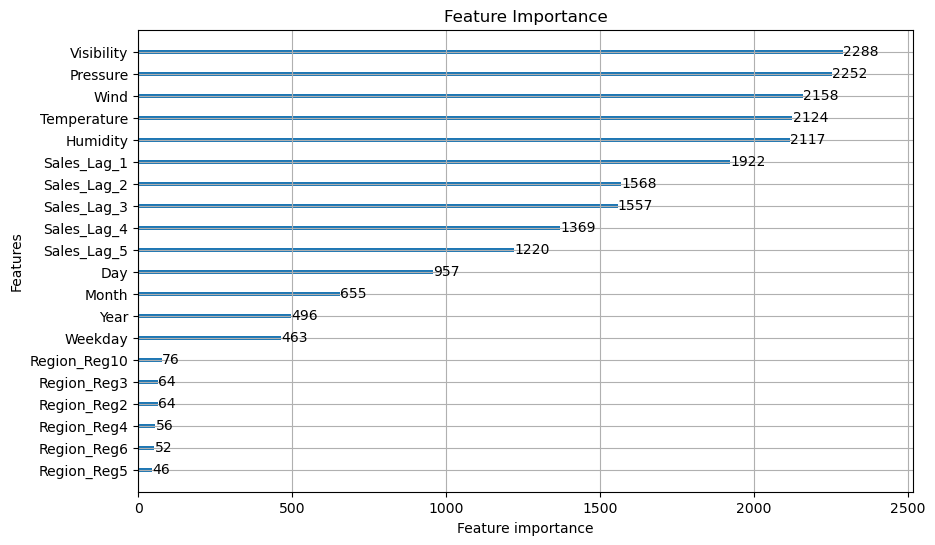

In [21]:
# Feature importance
lgb.plot_importance(model, max_num_features=20, importance_type='split', figsize=(10, 6))
plt.title('Feature Importance')
plt.show()